# Open Data From JSON

In [52]:
import pandas as pd
import numpy as np
import glob

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [54]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 23881
C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Preprocessing 

In [55]:
import re

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
df['id'] = df.index
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [57]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-57-e19db8f3f081>:3: DeprecationWarning: invalid escape sequence \.
  df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))


In [58]:
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

print("Tokenizing all articles. This may take a while.")
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continuing with lemmatization & noun extraction.")
i = 0
for element in df["tokenized_words"]:
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article
	i = i+1
	print(f"Lemmatizing & filtering nouns: {i}/{amount_of_articles}", flush=True)

df["maintext_nouns"] = nouns

3881
Lemmatizing & filtering nouns: 23417/23881
Lemmatizing & filtering nouns: 23418/23881
Lemmatizing & filtering nouns: 23419/23881
Lemmatizing & filtering nouns: 23420/23881
Lemmatizing & filtering nouns: 23421/23881
Lemmatizing & filtering nouns: 23422/23881
Lemmatizing & filtering nouns: 23423/23881
Lemmatizing & filtering nouns: 23424/23881
Lemmatizing & filtering nouns: 23425/23881
Lemmatizing & filtering nouns: 23426/23881
Lemmatizing & filtering nouns: 23427/23881
Lemmatizing & filtering nouns: 23428/23881
Lemmatizing & filtering nouns: 23429/23881
Lemmatizing & filtering nouns: 23430/23881
Lemmatizing & filtering nouns: 23431/23881
Lemmatizing & filtering nouns: 23432/23881
Lemmatizing & filtering nouns: 23433/23881
Lemmatizing & filtering nouns: 23434/23881
Lemmatizing & filtering nouns: 23435/23881
Lemmatizing & filtering nouns: 23436/23881
Lemmatizing & filtering nouns: 23437/23881
Lemmatizing & filtering nouns: 23438/23881
Lemmatizing & filtering nouns: 23439/23881
Lemmat

In [60]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

In [61]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Word Cloud All Words

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


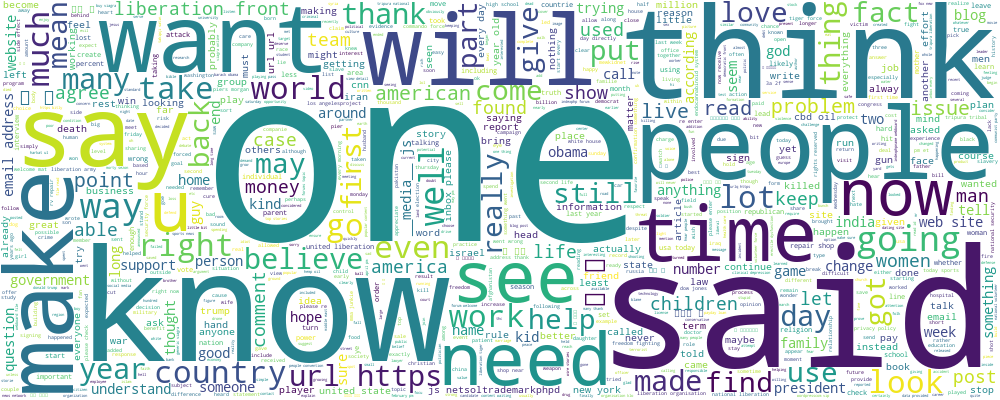

In [62]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


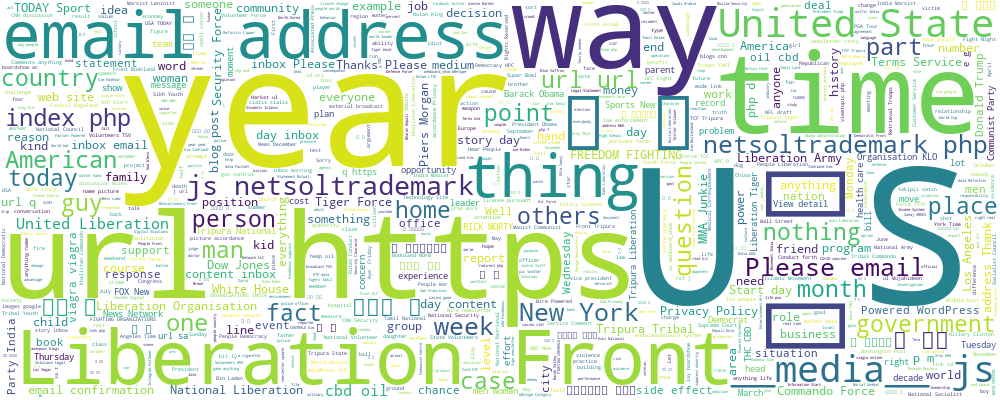

In [63]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

In [64]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json
import regex

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_alphanumeric(maintext_ready)
df["maintext_ready"]  = maintext_ready

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,..."


# Wordcloud of the ready-to-cluster articles

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


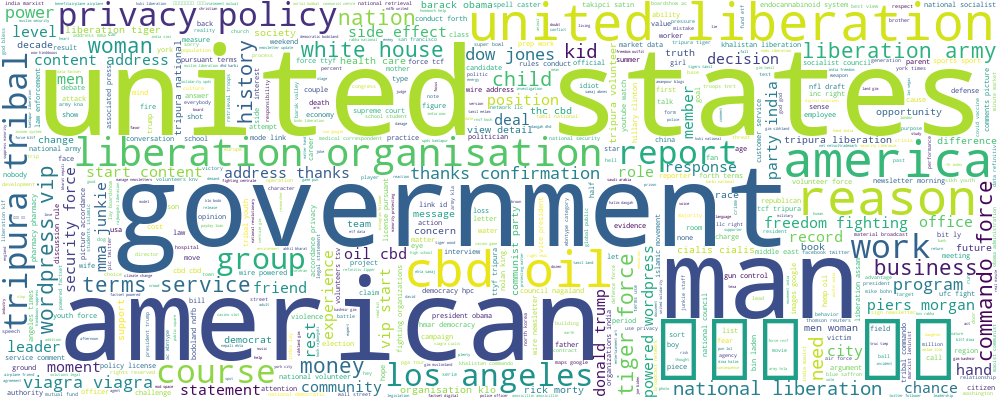

In [75]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

In [76]:
import gensim.corpora as corpora

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2..."
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ..."
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (56, 1), (84, 1), (97, 1), (..."


# Build a LDA model (need to find fitting values here)

In [92]:
from pprint import pprint   #pretty printing

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
amount_of_topics = 30  #adjust to find good results

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics)   #build the LDA model

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Displaying the LDA model

In [107]:
pprint(lda_model.print_topics())
articles_lda = lda_model[corpus]

[(24,
  '0.007*"force" + 0.006*"liberation" + 0.005*"tripura" + 0.004*"national" + '
  '0.003*"man" + 0.003*"india" + 0.003*"army" + 0.003*"child" + '
  '0.002*"president" + 0.002*"service"'),
 (8,
  '0.004*"viagra" + 0.003*"game" + 0.003*"cialis" + 0.003*"thanks" + '
  '0.003*"drug" + 0.003*"california" + 0.003*"team" + 0.002*"service" + '
  '0.002*"school" + 0.002*"money"'),
 (16,
  '0.008*"liberation" + 0.006*"force" + 0.006*"game" + 0.005*"team" + '
  '0.004*"national" + 0.004*"tripura" + 0.004*"united" + 0.004*"school" + '
  '0.003*"india" + 0.003*"view"'),
 (11,
  '0.003*"service" + 0.003*"help" + 0.003*"piers" + 0.003*"national" + '
  '0.003*"california" + 0.003*"money" + 0.003*"thanks" + 0.002*"force" + '
  '0.002*"child" + 0.002*"ufc"'),
 (0,
  '0.004*"woman" + 0.003*"man" + 0.003*"school" + 0.003*"child" + 0.003*"game" '
  '+ 0.002*"india" + 0.002*"team" + 0.002*"president" + 0.002*"student" + '
  '0.002*"policy"'),
 (19,
  '0.006*"force" + 0.005*"liberation" + 0.005*"preside

# Visualize the LDA model for further analysis (needed to find the best values to adjust)

In [108]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.013938  0.029236       1        1  9.616943
21     0.020490  0.002246       2        1  8.456041
3      0.008079  0.009904       3        1  5.869298
4     -0.000811 -0.001279       4        1  5.862698
19    -0.031970  0.011041       5        1  5.518914
18     0.013269  0.002767       6        1  5.378383
8      0.022876  0.027282       7        1  5.015606
24    -0.028257  0.003775       8        1  4.927552
5      0.033937 -0.003536       9        1  4.297229
20     0.005164 -0.017220      10        1  3.363086
10     0.015545  0.003860      11        1  3.324902
16    -0.029402 -0.006597      12        1  3.237344
1      0.000174  0.000183      13        1  3.057770
25     0.027408 -0.005417      14        1  2.948061
23    -0.017952 -0.049543      15        1  2.915312
7     -0.010278  0.000897      16        1  2.782722
14     0.021337 -0.034523      17        1  2.687231
0      0.016672  0.007325      18        1  2.673218
6      0.017831  0.002301      19        1  2.609979
28     0.004577 -0.002072      20        1  2.305214
29    -0.013602  0.007415      21        1  2.025763
9     -0.014442 -0.005556      22        1  1.811217
15     0.010983 -0.001605      23        1  1.627619
26    -0.018506  0.010145      24        1  1.452509
27    -0.013561  0.009632      25        1  1.419858
22    -0.027268 -0.009034      26        1  1.251154
11     0.007919  0.003983      27        1  1.140178
2     -0.003113 -0.005145      28        1  0.849338
12    -0.004800  0.010478      29        1  0.788042
13     0.001640 -0.000944      30        1  0.786821, topic_info=             Term          Freq         Total Category  logprob  loglift
8519          ufc  12220.000000  12220.000000  Default  30.0000  30.0000
1289        force  37771.000000  37771.000000  Default  29.0000  29.0000
44092         บอล  21298.000000  21298.000000  Default  28.0000  28.0000
833    liberation  29414.000000  29414.000000  Default  27.0000  27.0000
35425     tripura  25197.000000  25197.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
35425     tripura    143.900356  25197.487053  Topic30  -6.4166  -0.3205
1745          war    134.982964  20465.319612  Topic30  -6.4806  -0.1764
284         india    128.834757  23053.816886  Topic30  -6.5272  -0.3421
405        market    120.207563  13393.774342  Topic30  -6.5965   0.1316
308           man    123.474685  23711.032330  Topic30  -6.5697  -0.4127

[2687 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
177116     11  0.212503  abaya
177116     22  0.425006  abaya
1058        1  0.053738    abc
1058        2  0.082460    abc
1058        3  0.047252    abc
...       ...       ...    ...
44324      26  0.012202    ไหล
44324      27  0.003050    ไหล
44324      28  0.004576    ไหล
44324      29  0.003050    ไหล
44324      30  0.006101    ไหล

[18946 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 22, 4, 5, 20, 19, 9, 25, 6, 21, 11, 17, 2, 26, 24, 8, 15, 1, 7, 29, 30, 10, 16, 27, 28, 23, 12, 3, 13, 14])

# Store Cluster IDs to dataframe

In [110]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(9, '0.006*"force" + 0.005*"liberation" + 0.004*"india" + 0.004*"obama" + 0.003*"war"')
(1, '0.005*"game" + 0.004*"california" + 0.003*"force" + 0.003*"national" + 0.002*"health"')
(4, '0.004*"obama" + 0.004*"president" + 0.003*"force" + 0.003*"war" + 0.003*"game"')
(20, '0.006*"บอล" + 0.003*"วน" + 0.003*"government" + 0.003*"money" + 0.003*"national"')
(26, '0.008*"india" + 0.006*"force" + 0.005*"tripura" + 0.004*"liberation" + 0.004*"national"')
(0, '0.004*"woman" + 0.003*"man" + 0.003*"school" + 0.003*"child" + 0.003*"game"')
(5, '0.004*"obama" + 0.004*"iran" + 0.003*"data" + 0.003*"right" + 0.003*"president"')
(15, '0.004*"game" + 0.003*"force" + 0.002*"money" + 0.002*"บอล" + 0.002*"thanks"')
(16, '0.008*"liberation" + 0.006*"force" + 0.006*"game" + 0.005*"team" + 0.004*"national"')
(21, '0.004*"president" + 0.004*"child" + 0.003*"piers" + 0.003*"california" + 0.003*"trump"')
C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `shoul

In [111]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

for i, row in enumerate(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):   #get the dominant topic for each article
        if j == 0:  #dominant topic (only first one)
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topic_list.append(int(topic_num))
            topic_percentage_list.append(round(prop_topic,5))
            topic_keywords_list.append(topic_keywords)
        else: 
            break

df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords,month_year
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",19,0.97461,"force, liberation, president, tripura, season,...",2021-06
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",15,0.56862,"game, force, money, บอล, thanks, service, viag...",2021-06
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (56, 1), (84, 1), (97, 1), (...",25,0.62306,"india, ufc, child, obama, money, herpes, presi...",2021-06


In [113]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
import datetime as dt

df['date_publish'] = pd.to_datetime(df['date_publish'])
df['date_modify'] = pd.to_datetime(df['date_modify'])
df['date_modify'] = df['date_modify'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['date_download'] = pd.to_datetime(df['date_download'])
df['date_download'] = df['date_download'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df['date_publish'] = df['date_publish'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df.head(3)

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords,month_year
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",19,0.97461,"force, liberation, president, tripura, season,...",2021-06
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",15,0.56862,"game, force, money, บอล, thanks, service, viag...",2021-06
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (56, 1), (84, 1), (97, 1), (...",25,0.62306,"india, ufc, child, obama, money, herpes, presi...",2021-06


In [115]:
#df = df.drop(columns=["maintext_prepro", "tokenized_words", "maintext_nouns", "maintext_ready", "corpus", "id"])
df.head()

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords,month_year
0,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:15",Neighbors » Forums » General Discussion » Arti...,en,neighbors.denverpost.com,Neighbors » Forums » General Discussion » Arti...,Colorado poll: Majority favor allowing staff t...,http://neighbors.denverpost.com/viewtopic.php?...,0,neighbors » forums » general discussion » arti...,"[Neighbors, », Forums, », General, Discussion,...",Neighbors Forums General Discussion Article Ta...,"[neighbors, forums, general, discussion, talk,...","[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...",19,0.97461,"force, liberation, president, tripura, season,...",2021-06
1,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 10:50:55",Brands and publishers seeking esports sponsors...,en,deloitte.wsj.com,Brands and publishers seeking esports sponsors...,Esports on the Rise: Evaluating Brand ROI - C...,https://deloitte.wsj.com/cmo/2020/05/05/esport...,1,brands and publishers seeking esports sponsors...,"[Brands, and, publishers, seeking, esports, sp...",Brands publisher esports sponsorship opportuni...,"[brands, publisher, esports, sponsorship, oppo...","[(24, 1), (25, 1), (26, 1), (27, 7), (28, 1), ...",15,0.56862,"game, force, money, บอล, thanks, service, viag...",2021-06
2,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 12:45:16",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(3, 1), (24, 5), (56, 1), (84, 1), (97, 1), (...",25,0.62306,"india, ufc, child, obama, money, herpes, presi...",2021-06
3,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:08:18","Skip to main content Published: Jan 23, 2019 B...",en,jobs.washingtonpost.com,"Skip to main content Published: Jan 23, 2019By...",How Much Salary Negotiation Is Too Much?,https://jobs.washingtonpost.com/article/how-mu...,3,skip to main content published: jan 23 2019by ...,"[Skip, to, main, content, Published, :, Jan, 2...",Skip content Jan Arden Davidson salary balanci...,"[skip, content, arden, davidson, salary, balan...","[(33, 1), (43, 1), (51, 1), (173, 1), (184, 1)...",25,0.57323,"india, ufc, child, obama, money, herpes, presi...",2021-06
4,"07/14/2021, 01:00:35","07/14/2021, 01:00:35","06/12/2021, 11:09:30",One of artist Shepard Fairey's next projects c...,en,latimesblogs.latimes.com,One of artist Shepard Fairey's next projects ...,Shepard Fairey puts services up for auction | ...,https://latimesblogs.latimes.com/culturemonste...,4,one of artist shepard fairey's next projects ...,"[One, of, artist, Shepard, Fairey, 's, next, p...",artist Shepard Fairey project portrait Los Ang...,"[artist, shepard, fairey, project, portrait, l...","[(169, 1), (190, 1), (214, 1), (226, 2), (273,...",2,0.55635,"ufc, force, liberation, national, president, i...",2021-06


In [104]:
import json

for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    os.makedirs(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}')
    for date, _ in data.groupby(data.month_year):
             json_data = data.to_json(orient='records', force_ascii=False, date_format='iso', date_unit='s')
             parsed = json.loads(json_data)
             with open(f'./clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}/{date}.json', 'w', encoding='utf-8') as f:
                 f.write(json.dumps({"data": parsed}, indent=4, ensure_ascii=False))

C:\Users\snake\miniconda3\envs\kccs\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: './clustered_json/cluster_4-liberation_ force_ tripura'